# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
# Imports of all used packages and libraries
import sys
import os
import git
import glob
from collections import defaultdict

In [2]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [3]:
git_root

'/nancy/user/riwata/projects/reward_comp_ext'

In [4]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [7]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu
# import seaborn as sns



In [8]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorsys

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [11]:
import utilities.helper
import trodes.read_exported

In [12]:
FONTSIZE = 20

In [13]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

In [14]:
# Define a function to horizontally stack arrays
def stack_arrays(arrays):
    return np.vstack(arrays)

In [15]:
# BAND_TO_FREQ_PLOT = {'theta': (4, 12), 'gamma': (30, 50)}
BAND_TO_FREQ_PLOT = {'theta': (4, 12)}
BAND_TO_FREQ_COLOR = {'theta': "#FFAF00", 'beta': "blue", 'gamma': "green"}

## Inputs & Data

In [16]:
EPHYS_SAMPLE_RATE = 20000

In [17]:
# GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3", "5.2", "5.3"]
# GOOD_SUBJECTS = ["3.1", "4.2", "4.3"]
# GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3"]
GOOD_SUBJECTS = ["3.1", "3.3", "3.4", "4.2", "4.3", "5.2", "5.3"]


Explanation of each input and where it comes from.

In [18]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [19]:
# TRIAL_LABELS_DF = pd.read_excel("/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/reward_comp_ext/results/2024_06_26_sleap_clustering/data/rce_pilot_3_alone_comp_per_video_trial_labels.xlsx")
TRIALS_AND_SPECTRAL_DF = pd.read_pickle("./proc/rce_pilot_3_alone_comp_10_per_trial_spectral_bans_sleap.pkl")

In [20]:
FULL_LFP_TRACES_PKL = "{}_12_per_cluster_spectral_bans_sleap.pkl".format(OUTPUT_PREFIX)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions 

In [21]:
def combine_dicts(dicts):
    """
    Combine lists from multiple dictionaries that share the same key.

    This function takes a list of dictionaries where each dictionary's values are lists of numbers.
    It merges these lists for each corresponding key across all dictionaries, producing a single
    dictionary where each key has a combined list of all numbers from the input dictionaries.

    Parameters:
        dicts (list of dict): A list of dictionaries with values as lists of numbers.

    Returns:
        dict: A dictionary with keys from the input dictionaries and values as merged lists 
        of numbers from all corresponding input dictionary values.
    """
    combined = defaultdict(list)
    for dictionary in dicts:
        for key, value in dictionary.items():
            combined[key].extend(value)
    
    return dict(combined)


# Example usage
list_of_dicts = [
    {'a': [1, 2], 'b': [3, 4]},
    {'a': [5], 'b': [6, 7]},
    {'a': [8, 9], 'c': [10]}
]

combined_dict = combine_dicts(list_of_dicts)
print(combined_dict)

{'a': [1, 2, 5, 8, 9], 'b': [3, 4, 6, 7], 'c': [10]}


In [22]:
def find_consecutive_ranges(numbers, min_length=1):
    """
    Finds the start and end indices for consecutive ranges of each number in a list where the range meets a minimum length.

    This function iterates through a list of integers and identifies ranges where the same integer appears consecutively
    and the length of this sequence meets or exceeds the specified minimum length.

    Parameters:
        numbers (list): A list of integers to analyze for consecutive ranges.
        min_length (int): The minimum length of a range for it to be included in the results.

    Returns:
        dict: A dictionary with integers as keys and a list of tuples (start, end) as values,
              where each tuple represents the start and end indices (inclusive) of consecutive ranges
              for that integer. Only ranges that meet or exceed the minimum length are included.
    """
    ranges = {}
    n = len(numbers)
    if n == 0:
        return ranges
    
    start = 0
    current = numbers[0]

    for i in range(1, n):
        if numbers[i] != current:
            if (i - start) >= min_length:
                if current not in ranges:
                    ranges[current] = []
                ranges[current].append((start, i - 1))
            current = numbers[i]
            start = i

    # Handle the last range
    if (n - start) >= min_length:
        if current not in ranges:
            ranges[current] = []
        ranges[current].append((start, n - 1))

    return ranges

# Example usage:
numbers = [1, 1, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1]
print(find_consecutive_ranges(numbers, min_length=3))

{2: [(2, 4)], 3: [(5, 8)]}


In [23]:
def update_tuples_in_dict(original_dict, reference_list):
    """
    Updates the values in the tuples within a dictionary by replacing indices with corresponding values from a reference list.
    
    This function iterates through each key-value pair in the original dictionary. Each value is expected to be a list of tuples,
    where each tuple contains indices. These indices are used to fetch corresponding values from the reference list, creating new tuples.
    
    Parameters:
        original_dict (dict): Dictionary whose values are lists of tuples. Each tuple consists of indices into the reference_list.
        reference_list (list): List of elements that are referenced by the indices in the tuples of the original_dict.
        
    Returns:
        dict: A dictionary with the same keys as original_dict but with tuples transformed to contain elements from reference_list
              based on the indices in the original tuples.
    """
    # Create a new dictionary to store the updated key-value pairs
    new_dict = {}
    for key, list_of_tuples in original_dict.items():
        # Process each tuple in the list associated with the current key
        updated_tuples = [
            tuple(reference_list[idx] for idx in tup) for tup in list_of_tuples
        ]
        new_dict[key] = updated_tuples
    
    return new_dict

# Example usage:
original_dict = {
    'a': [(0, 1), (2, 3)],
    'b': [(1, 3), (0, 2)]
}
reference_list = ['alpha', 'beta', 'gamma', 'delta']

updated_dict = update_tuples_in_dict(original_dict, reference_list)
print(updated_dict)

{'a': [('alpha', 'beta'), ('gamma', 'delta')], 'b': [('beta', 'delta'), ('alpha', 'gamma')]}


In [24]:
def find_indices_within_ranges(ranges_dict, values):
    """
    Creates a dictionary mapping keys to sorted indices of values that fall within specified ranges.
    
    Parameters:
        ranges_dict (dict): A dictionary with keys and values as lists of tuples representing ranges.
        values (list): A list of values to check against the ranges.
        
    Returns:
        dict: A dictionary where each key maps to a sorted list of indices for values within the ranges.
    """
    result_dict = {}
    for key, ranges in ranges_dict.items():
        matched_indices = []
        for index, value in enumerate(values):
            if any(start <= value <= end for start, end in ranges):
                matched_indices.append(index)
        result_dict[key] = sorted(matched_indices)
    return list(result_dict.items())

# Example usage:
ranges_dict = {
    'range1': [(1, 5), (10, 15)],
    'range2': [(0, 2), (4, 8)]
}
values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

result = find_indices_within_ranges(ranges_dict, values)
print(result)


[('range1', [1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15]), ('range2', [0, 1, 2, 4, 5, 6, 7, 8])]


## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [25]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names




## Renaming the trial labels

In [26]:
TRIALS_AND_SPECTRAL_DF.head()

,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,box_1_port_entry_frames,...,trial_and_post_mPFC_gamma_phase,trial_and_post_mPFC_lfp_trace,trial_and_post_mPFC_theta_band,trial_and_post_mPFC_theta_phase,trial_and_post_vHPC_gamma_band,trial_and_post_vHPC_gamma_phase,trial_and_post_vHPC_lfp_trace,trial_and_post_vHPC_theta_band,trial_and_post_vHPC_theta_phase,trial_and_post_lfp_timestamps
0,34242.0,34322,34342.0,34442.0,4.3,After trial,NaN,NaN,NaN,[34250 34265],...,"[-2.8267386, -2.5752828, -2.3241265, -2.073247...","[74.295, 59.67, 49.53, 71.174995, 98.865, 105....","[0.45963967, 0.46584538, 0.4714166, 0.47629145...","[0.0660045, 0.100497134, 0.13558412, 0.1712443...","[-0.7498611, -0.73270696, -0.66639715, -0.5548...","[3.130545, -2.895104, -2.6377413, -2.380579, -...","[-194.60999, -213.915, -161.06999, -52.454998,...","[-0.7498519, -0.71976215, -0.68688864, -0.6512...","[-2.373418, -2.3229098, -2.2723296, -2.2216792...","[34280580, 34280600, 34280620, 34280640, 34280..."
1,34242.0,34322,34342.0,34442.0,4.3,After trial,NaN,NaN,NaN,[34250 34265],...,"[-2.4468, -2.2177749, -1.9918119, -1.7689933, ...","[19.695, 43.68, 68.25, 87.16499, 101.204994, 9...","[0.6209574, 0.6194976, 0.6152875, 0.6083768, 0...","[-0.14499341, -0.07693758, -0.008636221, 0.059...","[-0.012106158, 0.046377987, 0.09737586, 0.1367...","[-1.6299233, -1.3326924, -1.029256, -0.7194334...","[193.245, 173.54999, 157.36499, 132.405, 102.7...","[0.7059251, 0.6601463, 0.611616, 0.56049484, 0...","[0.86685646, 0.92562836, 0.984195, 1.0425555, ...","[34280580, 34280600, 34280620, 34280640, 34280..."
2,35241.0,35321,35341.0,35439.0,4.3,Subj 2 Only,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[-1.3393176, -1.0746405, -0.8121532, -0.552019...","[-42.12, -46.019997, -42.899998, -34.515, -29....","[-0.55376214, -0.54105306, -0.5277178, -0.5138...","[-2.848622, -2.809103, -2.7699904, -2.7312958,...","[0.029952968, 0.0829829, 0.13468696, 0.1792766...","[-1.3647506, -1.033497, -0.7162916, -0.40997, ...","[141.765, 137.08499, 126.74999, 128.89499, 140...","[0.3417526, 0.3667192, 0.38927597, 0.40933278,...","[-0.8138773, -0.7312234, -0.6479294, -0.564073...","[35280600, 35280620, 35280640, 35280660, 35280..."
3,35241.0,35321,35341.0,35439.0,4.3,Subj 2 Only,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[1.1835573, 1.3989904, 1.6151469, 1.8322233, 2...","[-84.24, -29.64, 8.969999, -31.005, -109.395, ...","[-0.43594536, -0.40849745, -0.37993425, -0.350...","[-2.290331, -2.2391956, -2.18775, -2.1359916, ...","[-0.04873953, 0.006628439, 0.061135184, 0.1117...","[-1.7751641, -1.5431039, -1.3114904, -1.080336...","[-134.355, -74.685, -16.965, -39.39, -100.8149...","[-0.3201336, -0.33739012, -0.3543125, -0.37081...","[2.4480984, 2.4920197, 2.5362623, 2.580803, 2....","[35280600, 35280620, 35280640, 35280660, 35280..."
4,36339.0,36419,36439.0,36538.0,4.3,Subj 2 blocking Subj 1,NaN,NaN,NaN,[36339 36354] [36361 36365] [36410 36473] [364...,...,"[1.9263768, 2.1613147, 2.397383, 2.634575, 2.8...","[7.995, 11.7, 12.674999, 5.85, -11.8949995, -3...","[0.04354602, 0.04824548, 0.050688196, 0.050923...","[-1.434966, -1.4083124, -1.3854433, -1.3673644...","[-0.22771999, -0.38629508, -0.5159725, -0.6101...","[1.8742249, 2.113802, 2.3528705, 2.5913677, 2....","[-279.435, -256.62, -195.58499, -120.314995, -...","[-0.76139945, -0.7329739, -0.7030888, -0.67182...","[-2.445381, -2.4016135, -2.3579578, -2.3144145...","[36380600, 36380620, 36380640, 36380660, 36380..."


In [27]:
comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

In [28]:
cluster_to_competitiveness = {"0": "no_comp", "1": "competitive", "2": "competitive", "3": "no_comp", "4": "competitive", "5": "no_comp", "6": "no_comp", "7": "no_comp"}
cluster_to_comp_id = {"0": "no_comp_8", "1": "competitive_3", "2": "competitive_1", "3": "no_comp_6", "4": "competitive_2", "5": "no_comp_7", "6": "no_comp_5", "7": "no_comp_4"}
comp_id = {"no_comp_8", "competitive_3", "competitive_1", "no_comp_6", "competitive_2", "no_comp_7", "no_comp_5", "no_comp_4"}


In [29]:
comp_id_to_color = {'competitive_1': "#281640",
 'competitive_2': "#43246a",
 'competitive_3': "#8e7ca6",
 'no_comp_4': "#2f3600",
 'no_comp_5': "#535f00",
 'no_comp_6': "#768800",
 'no_comp_7': "#9fac4d",
 'no_comp_8': "#c8cf99",
 'competitive': "#43246A",
 'no_comp': "#768800",
 'win': "#0045A6",
 'win_competitive': "#003074",
 'win_no_comp': "#4d7dc1",
 'lose': "#792910",
 'lose_competitive': "#551d0b",
 'lose_no_comp': "#a16958"
 }








Win base color
#0045A6 
Win competitive color
#003074
Win no comp color
#4d7dc1

Lose base color
#792910
Lose competitive color
#551d0b
Lose no comp color
#a16958

In [30]:
TRIALS_AND_SPECTRAL_DF["current_subject"] = TRIALS_AND_SPECTRAL_DF["current_subject"].apply(lambda x: str(x).strip().lower())

In [31]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["current_subject"].isin(GOOD_SUBJECTS)]

In [32]:
TRIALS_AND_SPECTRAL_DF["current_subject"].unique()

array(['4.2', '4.3', '3.3', '3.4', '3.1'], dtype=object)

In [33]:
TRIALS_AND_SPECTRAL_DF["condition "] = TRIALS_AND_SPECTRAL_DF["condition "].apply(lambda x: str(x).strip().lower())

In [34]:
TRIALS_AND_SPECTRAL_DF["trial_label"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: "win" if x["current_subject"] == x["condition "]  else ("lose" if x["agent"] == x["condition "] else "tie"), axis=1)
                                                                        

In [35]:
TRIALS_AND_SPECTRAL_DF["competition_closeness"] = TRIALS_AND_SPECTRAL_DF["competition_closeness"].map(comp_closeness_dict)

In [36]:
TRIALS_AND_SPECTRAL_DF["trial_label"]

0      lose
1       win
2      lose
3       win
4      lose
       ... 
196    lose
198    lose
200    lose
202    lose
204     tie
Name: trial_label, Length: 166, dtype: object

## Getting the ranges of each cluster

- Getting the index range

In [37]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'mPFC_lfp_RMS_filtered',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'vHPC_lfp_RMS_filtered',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'tr

In [38]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].iloc[0]

array([7, 7, 7, 7, 7, 7, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 7,
       7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [39]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_comp_id"] = TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].apply(lambda x: np.vectorize(cluster_to_comp_id.get)(x.astype(str)))

In [40]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_competitiveness"] = TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].apply(lambda x: np.vectorize(cluster_to_competitiveness.get)(x.astype(str)))

In [41]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_competitiveness"] 

0      [no_comp, no_comp, no_comp, no_comp, no_comp, ...
1      [no_comp, no_comp, no_comp, no_comp, no_comp, ...
2      [no_comp, no_comp, no_comp, no_comp, no_comp, ...
3      [no_comp, no_comp, no_comp, no_comp, no_comp, ...
4      [competitive, competitive, competitive, compet...
                             ...                        
196    [no_comp, no_comp, no_comp, no_comp, no_comp, ...
198    [competitive, competitive, competitive, compet...
200    [competitive, competitive, competitive, compet...
202    [no_comp, no_comp, no_comp, no_comp, no_comp, ...
204    [competitive, competitive, competitive, compet...
Name: trial_and_post_competitiveness, Length: 166, dtype: object

In [42]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_competitiveness"].iloc[0].shape

(400,)

In [43]:
# TRIALS_AND_SPECTRAL_DF["cluster_index_ranges_dict"] = TRIALS_AND_SPECTRAL_DF["trial_and_post_comp_id"].apply(lambda x: find_consecutive_ranges(x, min_length=20))

TRIALS_AND_SPECTRAL_DF["cluster_index_ranges_dict"] = TRIALS_AND_SPECTRAL_DF["trial_and_post_competitiveness"].apply(lambda x: find_consecutive_ranges(x[:200], min_length=20))


In [44]:
TRIALS_AND_SPECTRAL_DF["cluster_index_ranges_dict"].iloc[0]

{'no_comp': [(9, 199)]}

In [45]:
TRIALS_AND_SPECTRAL_DF.head()

,tone_start_frame,reward_start,reward_dispensed,tone_stop_frame,condition,competition_closeness,get_reward_frame,out_reward_frame,notes,box_1_port_entry_frames,...,trial_and_post_vHPC_gamma_band,trial_and_post_vHPC_gamma_phase,trial_and_post_vHPC_lfp_trace,trial_and_post_vHPC_theta_band,trial_and_post_vHPC_theta_phase,trial_and_post_lfp_timestamps,trial_label,trial_and_post_comp_id,trial_and_post_competitiveness,cluster_index_ranges_dict
0,34242.0,34322,34342.0,34442.0,4.3,no_comp,NaN,NaN,NaN,[34250 34265],...,"[-0.7498611, -0.73270696, -0.66639715, -0.5548...","[3.130545, -2.895104, -2.6377413, -2.380579, -...","[-194.60999, -213.915, -161.06999, -52.454998,...","[-0.7498519, -0.71976215, -0.68688864, -0.6512...","[-2.373418, -2.3229098, -2.2723296, -2.2216792...","[34280580, 34280600, 34280620, 34280640, 34280...",lose,"[no_comp_4, no_comp_4, no_comp_4, no_comp_4, n...","[no_comp, no_comp, no_comp, no_comp, no_comp, ...","{'no_comp': [(9, 199)]}"
1,34242.0,34322,34342.0,34442.0,4.3,no_comp,NaN,NaN,NaN,[34250 34265],...,"[-0.012106158, 0.046377987, 0.09737586, 0.1367...","[-1.6299233, -1.3326924, -1.029256, -0.7194334...","[193.245, 173.54999, 157.36499, 132.405, 102.7...","[0.7059251, 0.6601463, 0.611616, 0.56049484, 0...","[0.86685646, 0.92562836, 0.984195, 1.0425555, ...","[34280580, 34280600, 34280620, 34280640, 34280...",win,"[no_comp_4, no_comp_4, no_comp_4, no_comp_4, n...","[no_comp, no_comp, no_comp, no_comp, no_comp, ...","{'no_comp': [(9, 199)]}"
2,35241.0,35321,35341.0,35439.0,4.3,no_comp,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[0.029952968, 0.0829829, 0.13468696, 0.1792766...","[-1.3647506, -1.033497, -0.7162916, -0.40997, ...","[141.765, 137.08499, 126.74999, 128.89499, 140...","[0.3417526, 0.3667192, 0.38927597, 0.40933278,...","[-0.8138773, -0.7312234, -0.6479294, -0.564073...","[35280600, 35280620, 35280640, 35280660, 35280...",lose,"[no_comp_8, no_comp_8, no_comp_8, no_comp_8, n...","[no_comp, no_comp, no_comp, no_comp, no_comp, ...","{'no_comp': [(0, 180)]}"
3,35241.0,35321,35341.0,35439.0,4.3,no_comp,NaN,NaN,NaN,[35242 35249] [35249 35250] [35250 35271] [353...,...,"[-0.04873953, 0.006628439, 0.061135184, 0.1117...","[-1.7751641, -1.5431039, -1.3114904, -1.080336...","[-134.355, -74.685, -16.965, -39.39, -100.8149...","[-0.3201336, -0.33739012, -0.3543125, -0.37081...","[2.4480984, 2.4920197, 2.5362623, 2.580803, 2....","[35280600, 35280620, 35280640, 35280660, 35280...",win,"[no_comp_8, no_comp_8, no_comp_8, no_comp_8, n...","[no_comp, no_comp, no_comp, no_comp, no_comp, ...","{'no_comp': [(0, 180)]}"
4,36339.0,36419,36439.0,36538.0,4.3,competitive,NaN,NaN,NaN,[36339 36354] [36361 36365] [36410 36473] [364...,...,"[-0.22771999, -0.38629508, -0.5159725, -0.6101...","[1.8742249, 2.113802, 2.3528705, 2.5913677, 2....","[-279.435, -256.62, -195.58499, -120.314995, -...","[-0.76139945, -0.7329739, -0.7030888, -0.67182...","[-2.445381, -2.4016135, -2.3579578, -2.3144145...","[36380600, 36380620, 36380640, 36380660, 36380...",lose,"[competitive_3, competitive_3, competitive_3, ...","[competitive, competitive, competitive, compet...","{'competitive': [(9, 44), (52, 72), (175, 199)..."


In [46]:
TRIALS_AND_SPECTRAL_DF["cluster_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["video_timestamps"][x["trial_and_post_frame_index"]], axis=1)


- Calculating the times in milliseconds of each cluster frame

In [47]:
TRIALS_AND_SPECTRAL_DF["cluster_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: (np.array(x["cluster_timestamp"]) - x["first_timestamp"]) // 20, axis=1)


- Updating the index to use cluster times and timestamps based on video frame timestamps list

In [48]:
TRIALS_AND_SPECTRAL_DF["cluster_times_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_dict(x["cluster_index_ranges_dict"], x["cluster_times"]), axis=1)

In [49]:
TRIALS_AND_SPECTRAL_DF["cluster_timestamps_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: update_tuples_in_dict(x["cluster_index_ranges_dict"], x["cluster_timestamp"]), axis=1)

- Combining the win and loss label with the cluster

In [50]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_times_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: {"{}_{}".format(x["trial_label"], k): v for k, v in x["cluster_times_ranges_dict"].items()}, axis=1)


In [51]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_timestamps_ranges_dict"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: {"{}_{}".format(x["trial_label"], k): v for k, v in x["cluster_timestamps_ranges_dict"].items()}, axis=1)


In [52]:
TRIALS_AND_SPECTRAL_DF["trial_cluster_timestamps_ranges_dict"].iloc[0]

{'lose_no_comp': [(34289183, 34480433)]}

In [53]:
TRIALS_AND_SPECTRAL_DF.columns

Index(['tone_start_frame', 'reward_start', 'reward_dispensed',
       'tone_stop_frame', 'condition ', 'competition_closeness',
       'get_reward_frame', 'out_reward_frame', 'notes',
       'box_1_port_entry_frames',
       ...
       'trial_label', 'trial_and_post_comp_id',
       'trial_and_post_competitiveness', 'cluster_index_ranges_dict',
       'cluster_timestamp', 'cluster_times', 'cluster_times_ranges_dict',
       'cluster_timestamps_ranges_dict', 'trial_cluster_times_ranges_dict',
       'trial_cluster_timestamps_ranges_dict'],
      dtype='object', length=218)

In [54]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_coherence_timestamps"].iloc[0]

array([34290000, 34300000, 34310000, 34320000, 34330000, 34340000,
       34350000, 34360000, 34370000, 34380000, 34390000, 34400000,
       34410000, 34420000, 34430000, 34440000, 34450000, 34460000,
       34470000, 34480000, 34490000, 34500000, 34510000, 34520000,
       34530000, 34540000, 34550000, 34560000, 34570000, 34580000,
       34590000, 34600000, 34610000, 34620000, 34630000, 34640000,
       34650000, 34660000, 34670000, 34680000])

In [55]:
timestamps_col = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "timestamps" in col and "trial_and_post" in col and "video" not in col]

In [56]:
timestamps_col

['trial_and_post_coherence_timestamps',
 'trial_and_post_granger_timestamps',
 'trial_and_post_power_timestamps',
 'trial_and_post_lfp_timestamps']

- Getting all the indexes that fit within each range

In [57]:
for col in timestamps_col:
    base_col = col.replace("trial_and_post_", "")
    TRIALS_AND_SPECTRAL_DF["cluster_filtered_{}".format(base_col)] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: find_indices_within_ranges(x["trial_cluster_timestamps_ranges_dict"], x[col]), axis=1)

# Filtering for power

In [58]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: len(x)) >= 1] 

In [59]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'mPFC_lfp_RMS_filtered',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'vHPC_lfp_RMS_filtered',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'tr

In [60]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition ',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

In [61]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF if "power" in col and ("trial_and_post" in col or "cluster" in col)]

In [62]:
power_columns

['trial_and_post_BLA_power_all_frequencies_all_windows',
 'trial_and_post_BLA_power_gamma',
 'trial_and_post_BLA_power_theta',
 'trial_and_post_LH_power_all_frequencies_all_windows',
 'trial_and_post_LH_power_gamma',
 'trial_and_post_LH_power_theta',
 'trial_and_post_MD_power_all_frequencies_all_windows',
 'trial_and_post_MD_power_gamma',
 'trial_and_post_MD_power_theta',
 'trial_and_post_mPFC_power_all_frequencies_all_windows',
 'trial_and_post_mPFC_power_gamma',
 'trial_and_post_mPFC_power_theta',
 'trial_and_post_vHPC_power_all_frequencies_all_windows',
 'trial_and_post_vHPC_power_gamma',
 'trial_and_post_vHPC_power_theta',
 'trial_and_post_power_timestamps',
 'cluster_filtered_power_timestamps']

- Making a separate row for each cluster

In [63]:
power_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[to_keep_columns + power_columns].explode(["cluster_filtered_power_timestamps"])

In [64]:
power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"]

0      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
1      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
2      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
3      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
4        (lose_competitive, [1, 2, 3, 5, 6, 17, 18, 19])
                             ...                        
200    (lose_competitive, [4, 5, 6, 7, 15, 16, 17, 18...
200                  (lose_no_comp, [9, 10, 11, 12, 13])
202    (lose_no_comp, [4, 5, 6, 7, 8, 9, 10, 11, 12, ...
204    (tie_competitive, [0, 1, 4, 5, 6, 7, 8, 9, 10,...
204                                (tie_no_comp, [2, 3])
Name: cluster_filtered_power_timestamps, Length: 252, dtype: object

- Making independent columns for cluster name and indexes

In [65]:
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: x[0])
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_indexes"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_power_timestamps"].apply(lambda x: x[1])

In [66]:
power_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "power" in col and "trial_and_post" in col and "timestamps" not in col]

In [67]:
power_columns

['trial_and_post_BLA_power_all_frequencies_all_windows',
 'trial_and_post_BLA_power_gamma',
 'trial_and_post_BLA_power_theta',
 'trial_and_post_LH_power_all_frequencies_all_windows',
 'trial_and_post_LH_power_gamma',
 'trial_and_post_LH_power_theta',
 'trial_and_post_MD_power_all_frequencies_all_windows',
 'trial_and_post_MD_power_gamma',
 'trial_and_post_MD_power_theta',
 'trial_and_post_mPFC_power_all_frequencies_all_windows',
 'trial_and_post_mPFC_power_gamma',
 'trial_and_post_mPFC_power_theta',
 'trial_and_post_vHPC_power_all_frequencies_all_windows',
 'trial_and_post_vHPC_power_gamma',
 'trial_and_post_vHPC_power_theta']

- Getting the timestamps of all the clusters

In [68]:
for col in power_columns:
    power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["power_cluster_indexes"]], axis=1)

In [69]:
cluster_all_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [70]:
cluster_all_columns

['cluster_all_trial_and_post_BLA_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_power_gamma',
 'cluster_all_trial_and_post_BLA_power_theta',
 'cluster_all_trial_and_post_LH_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_LH_power_gamma',
 'cluster_all_trial_and_post_LH_power_theta',
 'cluster_all_trial_and_post_MD_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_MD_power_gamma',
 'cluster_all_trial_and_post_MD_power_theta',
 'cluster_all_trial_and_post_mPFC_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_mPFC_power_gamma',
 'cluster_all_trial_and_post_mPFC_power_theta',
 'cluster_all_trial_and_post_vHPC_power_all_frequencies_all_windows',
 'cluster_all_trial_and_post_vHPC_power_gamma',
 'cluster_all_trial_and_post_vHPC_power_theta']

- Aggregating all the values within a given trial

In [71]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    print(updated_column)
    print(power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

cluster_mean_trial_and_post_BLA_power_all_frequencies_all_windows
[0.00629591 0.0098245  0.02053476 0.03022996 0.03108717 0.02700315
 0.02310144 0.01995291 0.04337556 0.04806644 0.04242995 0.0293251
 0.01183534 0.00986338 0.00707626 0.00653566 0.00573355 0.0050081
 0.00544805 0.00502358 0.00498729 0.00376167 0.00375937 0.0035777
 0.0037024  0.00342508 0.00338309 0.00329608 0.00346749 0.00360755
 0.00492882 0.00465192 0.00492924 0.0040972  0.00452026 0.00432695
 0.00469974 0.00552833 0.00496867 0.00386262 0.00348597 0.00331216
 0.00315149 0.00339775 0.00307639 0.00264599 0.00188621 0.00138538
 0.00143328 0.00146297 0.0015015  0.00137298 0.00117254 0.0012163
 0.00114156 0.00127783]
cluster_mean_trial_and_post_BLA_power_gamma
0.0034882294
cluster_mean_trial_and_post_BLA_power_theta
0.030686341
cluster_mean_trial_and_post_LH_power_all_frequencies_all_windows
[0.00975185 0.018228   0.03473853 0.0382997  0.02438965 0.01853094
 0.00668552 0.01053041 0.02713153 0.03244472 0.03703909 0.02778669

In [72]:
cluster_mean_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col]

In [73]:
cluster_mean_columns

['cluster_mean_trial_and_post_BLA_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_power_gamma',
 'cluster_mean_trial_and_post_BLA_power_theta',
 'cluster_mean_trial_and_post_LH_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_LH_power_gamma',
 'cluster_mean_trial_and_post_LH_power_theta',
 'cluster_mean_trial_and_post_MD_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_MD_power_gamma',
 'cluster_mean_trial_and_post_MD_power_theta',
 'cluster_mean_trial_and_post_mPFC_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_mPFC_power_gamma',
 'cluster_mean_trial_and_post_mPFC_power_theta',
 'cluster_mean_trial_and_post_vHPC_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_vHPC_power_gamma',
 'cluster_mean_trial_and_post_vHPC_power_theta']

In [74]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [75]:
cluster_mean_columns

['cluster_mean_trial_and_post_BLA_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_power_gamma',
 'cluster_mean_trial_and_post_BLA_power_theta',
 'cluster_mean_trial_and_post_LH_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_LH_power_gamma',
 'cluster_mean_trial_and_post_LH_power_theta',
 'cluster_mean_trial_and_post_MD_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_MD_power_gamma',
 'cluster_mean_trial_and_post_MD_power_theta',
 'cluster_mean_trial_and_post_mPFC_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_mPFC_power_gamma',
 'cluster_mean_trial_and_post_mPFC_power_theta',
 'cluster_mean_trial_and_post_vHPC_power_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_vHPC_power_gamma',
 'cluster_mean_trial_and_post_vHPC_power_theta']

cluster_mean_trial_and_post_BLA_power_all_frequencies_all_windows


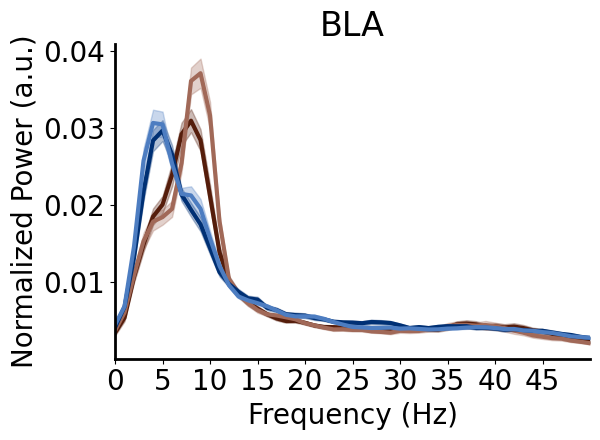

cluster_mean_trial_and_post_LH_power_all_frequencies_all_windows


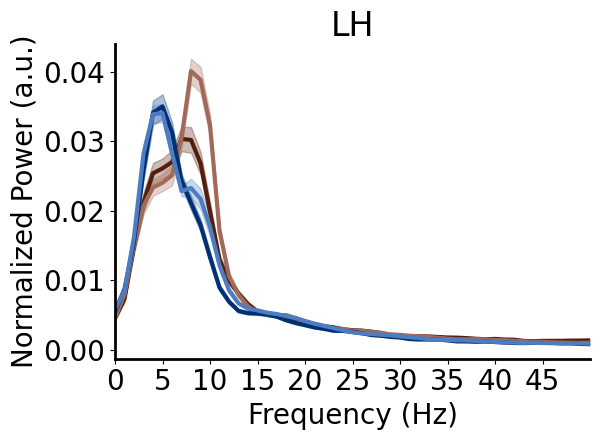

cluster_mean_trial_and_post_MD_power_all_frequencies_all_windows


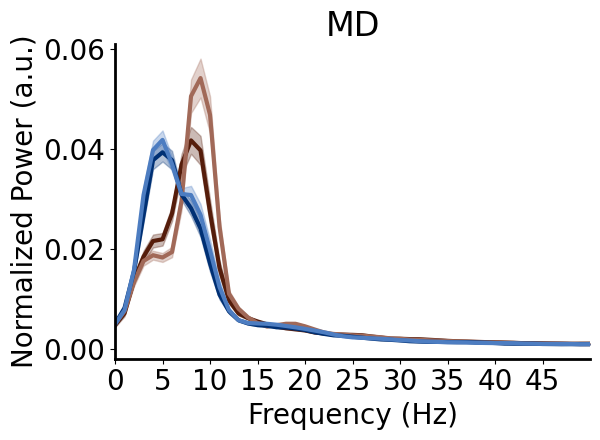

cluster_mean_trial_and_post_mPFC_power_all_frequencies_all_windows


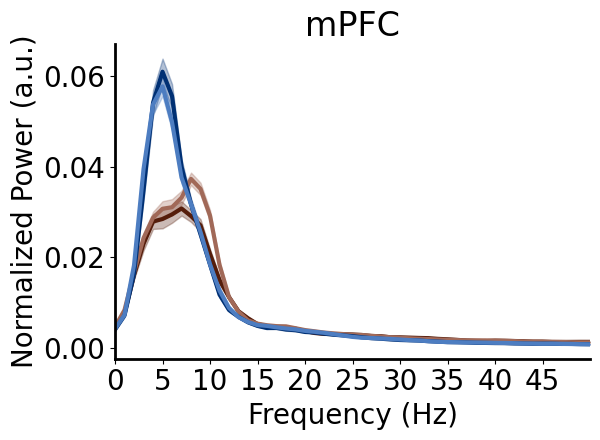

cluster_mean_trial_and_post_vHPC_power_all_frequencies_all_windows


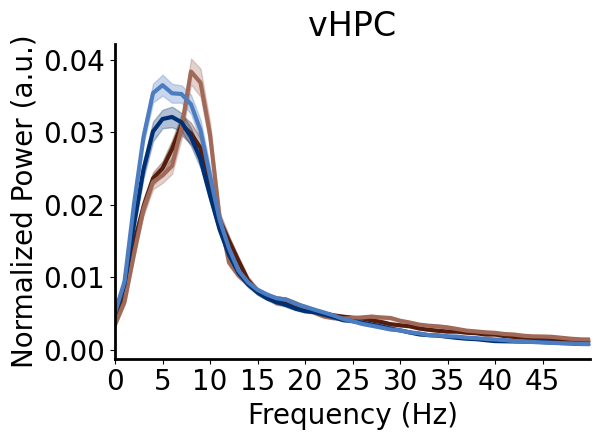

In [76]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each brain region
for col in cluster_mean_columns:
    if "all_frequencies" not in col:
        continue
    print(col)

    fig, ax = plt.subplots()
    plt.xlim(low_freq, high_freq-1) 
    plt.xticks(np.arange(low_freq, high_freq-1, 5))
    # plt.grid()

    # for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
    #     ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.3, label=band)

    stacked_df = power_exploded_TRIALS_AND_SPECTRAL_DF.groupby("power_cluster_id").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    
    # grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())

    stacked_df["color"] = stacked_df["power_cluster_id"].map(comp_id_to_color)

    stacked_df["max_value"] = stacked_df[col].apply(lambda x: np.nanmax(x[low_freq: high_freq]))
    max_value = np.nanmax(stacked_df["max_value"])
    
    # Iterating through each trial type
    for trial_label in stacked_df["power_cluster_id"].unique():
        if "tie" in trial_label:
            continue
        
        current_df = stacked_df[stacked_df["power_cluster_id"] == trial_label]
    
        if "power" in col:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            # plt.set_ylim(auto=True)
            plt.ylim()
            # plt.ylim(0, max_value)
        else:
            # pass
            plt.ylim(0, 1)

        # current_df["id_number"] = current_df["id_number"].astype(int)
        # Sample data: a list of numbers
        

        
        for index, row in current_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            # sem_power = stats.sem(row[col], axis=0, ddof=0)
            
            sem_power = np.nanstd(row[col], axis=0) / ((row[col].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   
            

            plt.plot(current_frequencies, mean_power, \
            label="{}".format(row["power_cluster_id"]), linewidth=3, color=row["color"])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.3, color=row["color"])
    
    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    
    if "power" in col:
        plt.ylabel("Normalized Power (a.u.)")
        output_dir = "./proc/cluster_spectra_plots/power"

    elif "coherence" in col:
        plt.ylabel("Coherence")
        output_dir = "./proc/cluster_spectra_plots/coherence"

    elif "granger" in col:
        plt.ylabel("Granger's Causality")
        output_dir = "./proc/cluster_spectra_plots/granger"
    
    os.makedirs(output_dir, exist_ok=True)

    # plt.legend(fontsize=10)

    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.tight_layout()    
    plt.savefig(os.path.join(output_dir, "cluster_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())))
    plt.show()


    







# Filtering for coherence

In [77]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["cluster_filtered_coherence_timestamps"].apply(lambda x: len(x)) >= 1] 

In [78]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'mPFC_lfp_RMS_filtered',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'vHPC_lfp_RMS_filtered',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'tr

In [79]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition ',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

In [80]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF if "coherence" in col and ("trial_and_post" in col or "cluster" in col)]

In [81]:
power_columns

['trial_and_post_BLA_LH_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_LH_coherence_gamma',
 'trial_and_post_BLA_LH_coherence_theta',
 'trial_and_post_BLA_MD_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_MD_coherence_gamma',
 'trial_and_post_BLA_MD_coherence_theta',
 'trial_and_post_BLA_mPFC_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_mPFC_coherence_gamma',
 'trial_and_post_BLA_mPFC_coherence_theta',
 'trial_and_post_BLA_vHPC_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_vHPC_coherence_gamma',
 'trial_and_post_BLA_vHPC_coherence_theta',
 'trial_and_post_LH_MD_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_MD_coherence_gamma',
 'trial_and_post_LH_MD_coherence_theta',
 'trial_and_post_LH_mPFC_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_mPFC_coherence_gamma',
 'trial_and_post_LH_mPFC_coherence_theta',
 'trial_and_post_LH_vHPC_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_vHPC_coherence_

- Making a separate row for each cluster

In [82]:
power_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[to_keep_columns + power_columns].explode(["cluster_filtered_coherence_timestamps"])

In [83]:
power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_coherence_timestamps"]

0      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
1      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
2      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
3      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
4        (lose_competitive, [1, 2, 3, 5, 6, 17, 18, 19])
                             ...                        
200    (lose_competitive, [4, 5, 6, 7, 15, 16, 17, 18...
200                  (lose_no_comp, [9, 10, 11, 12, 13])
202    (lose_no_comp, [4, 5, 6, 7, 8, 9, 10, 11, 12, ...
204    (tie_competitive, [0, 1, 4, 5, 6, 7, 8, 9, 10,...
204                                (tie_no_comp, [2, 3])
Name: cluster_filtered_coherence_timestamps, Length: 252, dtype: object

- Making independent columns for cluster name and indexes

In [84]:
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_coherence_timestamps"].apply(lambda x: x[0])
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_indexes"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_coherence_timestamps"].apply(lambda x: x[1])

In [85]:
power_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "coherence" in col and "trial_and_post" in col and "timestamps" not in col]

In [86]:
power_columns

['trial_and_post_BLA_LH_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_LH_coherence_gamma',
 'trial_and_post_BLA_LH_coherence_theta',
 'trial_and_post_BLA_MD_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_MD_coherence_gamma',
 'trial_and_post_BLA_MD_coherence_theta',
 'trial_and_post_BLA_mPFC_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_mPFC_coherence_gamma',
 'trial_and_post_BLA_mPFC_coherence_theta',
 'trial_and_post_BLA_vHPC_coherence_all_frequencies_all_windows',
 'trial_and_post_BLA_vHPC_coherence_gamma',
 'trial_and_post_BLA_vHPC_coherence_theta',
 'trial_and_post_LH_MD_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_MD_coherence_gamma',
 'trial_and_post_LH_MD_coherence_theta',
 'trial_and_post_LH_mPFC_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_mPFC_coherence_gamma',
 'trial_and_post_LH_mPFC_coherence_theta',
 'trial_and_post_LH_vHPC_coherence_all_frequencies_all_windows',
 'trial_and_post_LH_vHPC_coherence_

- Getting the timestamps of all the clusters

In [87]:
for col in power_columns:
    power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["power_cluster_indexes"]], axis=1)

In [88]:
cluster_all_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [89]:
cluster_all_columns

['cluster_all_trial_and_post_BLA_LH_coherence_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_LH_coherence_gamma',
 'cluster_all_trial_and_post_BLA_LH_coherence_theta',
 'cluster_all_trial_and_post_BLA_MD_coherence_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_MD_coherence_gamma',
 'cluster_all_trial_and_post_BLA_MD_coherence_theta',
 'cluster_all_trial_and_post_BLA_mPFC_coherence_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_mPFC_coherence_gamma',
 'cluster_all_trial_and_post_BLA_mPFC_coherence_theta',
 'cluster_all_trial_and_post_BLA_vHPC_coherence_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_vHPC_coherence_gamma',
 'cluster_all_trial_and_post_BLA_vHPC_coherence_theta',
 'cluster_all_trial_and_post_LH_MD_coherence_all_frequencies_all_windows',
 'cluster_all_trial_and_post_LH_MD_coherence_gamma',
 'cluster_all_trial_and_post_LH_MD_coherence_theta',
 'cluster_all_trial_and_post_LH_mPFC_coherence_all_frequencies_all_wind

- Aggregating all the values within a given trial

In [90]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    print(updated_column)
    print(power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

cluster_mean_trial_and_post_BLA_LH_coherence_all_frequencies_all_windows
[0.9697732  0.5263027  0.6099979  0.59411645 0.4519348  0.49482772
 0.49634898 0.04705689 0.6702861  0.76966727 0.657007   0.81099874
 0.8082179  0.52165425 0.39909932 0.76540136 0.5609455  0.4226656
 0.37796068 0.48962617 0.67169994 0.6181386  0.28687483 0.23245597
 0.79859614 0.798601   0.31740475 0.18394312 0.21028627 0.47399217
 0.44233721 0.5232168  0.63408    0.57453144 0.57258475 0.39109376
 0.6053612  0.29704005 0.3798874  0.6576196  0.9133854  0.86435014
 0.47332305 0.3526598  0.26019636 0.44435638 0.36891598 0.12750322
 0.25592786 0.31287214 0.20891118 0.14035875 0.25174224 0.26731235
 0.24599528 0.16296694]
cluster_mean_trial_and_post_BLA_LH_coherence_gamma
0.46000734
cluster_mean_trial_and_post_BLA_LH_coherence_theta
0.5784828
cluster_mean_trial_and_post_BLA_MD_coherence_all_frequencies_all_windows
[0.76884705 0.7989592  0.7546541  0.7451162  0.713517   0.70139444
 0.6680965  0.71678686 0.8682298  0.92

In [91]:
cluster_mean_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col]

In [92]:
cluster_mean_columns

['cluster_mean_trial_and_post_BLA_LH_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_LH_coherence_gamma',
 'cluster_mean_trial_and_post_BLA_LH_coherence_theta',
 'cluster_mean_trial_and_post_BLA_MD_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_MD_coherence_gamma',
 'cluster_mean_trial_and_post_BLA_MD_coherence_theta',
 'cluster_mean_trial_and_post_BLA_mPFC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_mPFC_coherence_gamma',
 'cluster_mean_trial_and_post_BLA_mPFC_coherence_theta',
 'cluster_mean_trial_and_post_BLA_vHPC_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_vHPC_coherence_gamma',
 'cluster_mean_trial_and_post_BLA_vHPC_coherence_theta',
 'cluster_mean_trial_and_post_LH_MD_coherence_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_LH_MD_coherence_gamma',
 'cluster_mean_trial_and_post_LH_MD_coherence_theta',
 'cluster_mean_trial_and_post_LH_mPFC_coherence_all_freq

In [93]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [94]:
# for col in cluster_mean_columns:
#     if "all_frequencies" in col:
#         continue
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = pd.DataFrame(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].mean())
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.reset_index()



#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["id_number"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)

    
    
#     fig, ax = plt.subplots()
#     plt.bar(grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"], grouped_power_exploded_TRIALS_AND_SPECTRAL_DF[col], color=grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"])
#     plt.title(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", ""))
#     plt.xticks(rotation=90, ha='right')
#     plt.show()

cluster_mean_trial_and_post_BLA_LH_coherence_all_frequencies_all_windows


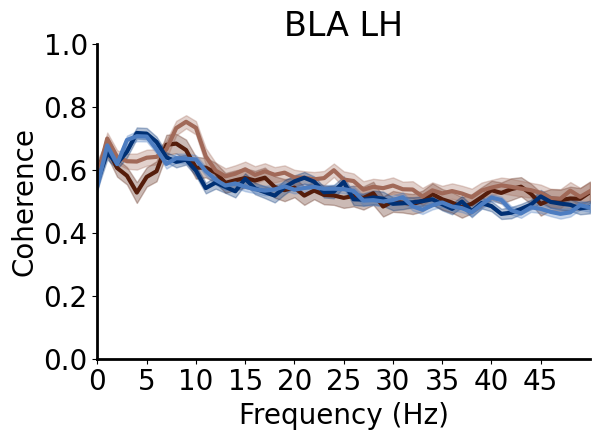

cluster_mean_trial_and_post_BLA_MD_coherence_all_frequencies_all_windows


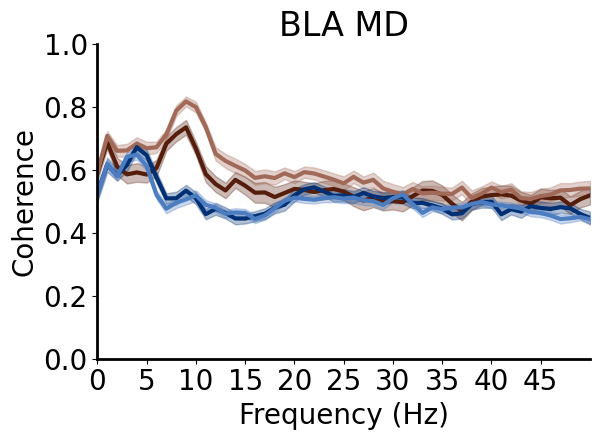

cluster_mean_trial_and_post_BLA_mPFC_coherence_all_frequencies_all_windows


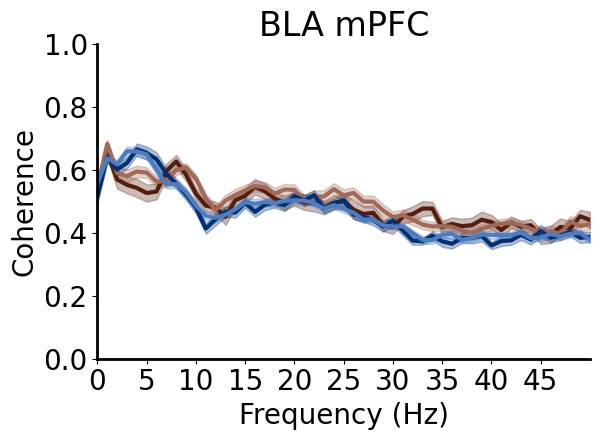

cluster_mean_trial_and_post_BLA_vHPC_coherence_all_frequencies_all_windows


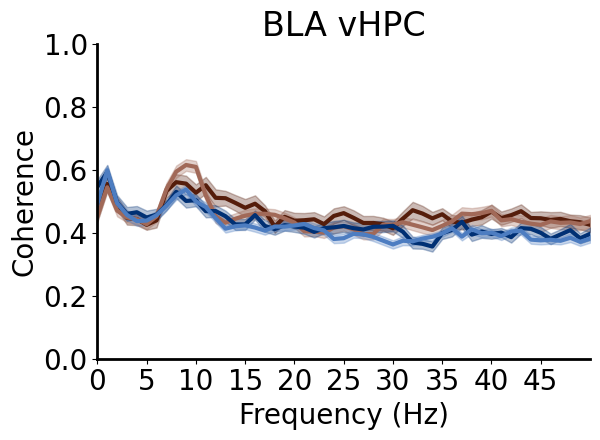

cluster_mean_trial_and_post_LH_MD_coherence_all_frequencies_all_windows


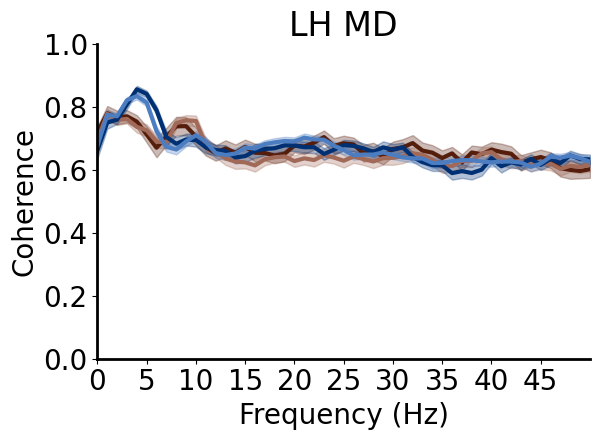

cluster_mean_trial_and_post_LH_mPFC_coherence_all_frequencies_all_windows


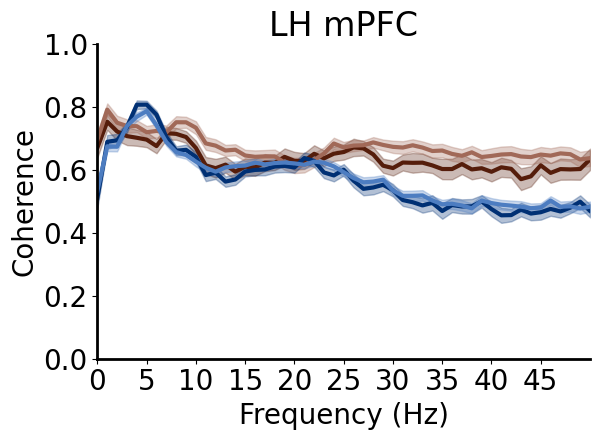

cluster_mean_trial_and_post_LH_vHPC_coherence_all_frequencies_all_windows


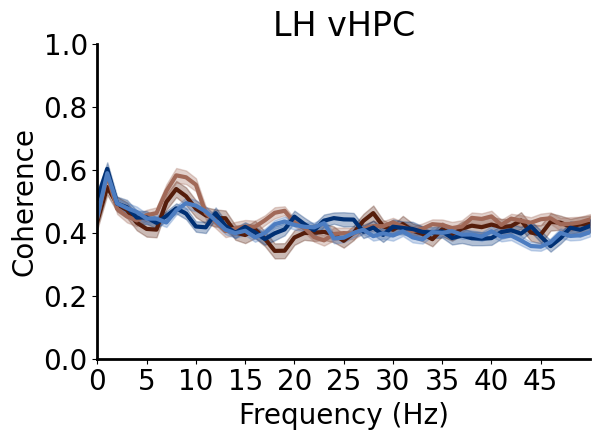

cluster_mean_trial_and_post_MD_mPFC_coherence_all_frequencies_all_windows


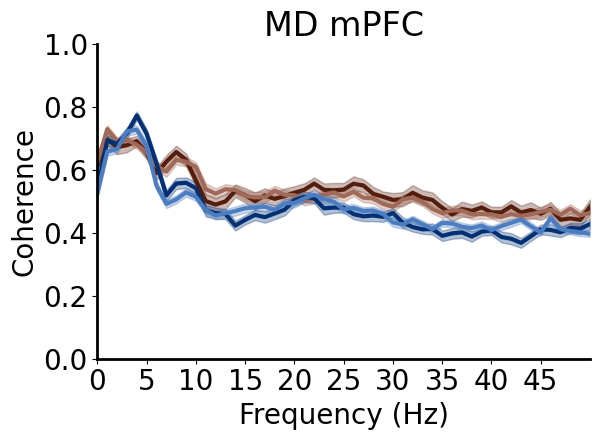

cluster_mean_trial_and_post_MD_vHPC_coherence_all_frequencies_all_windows


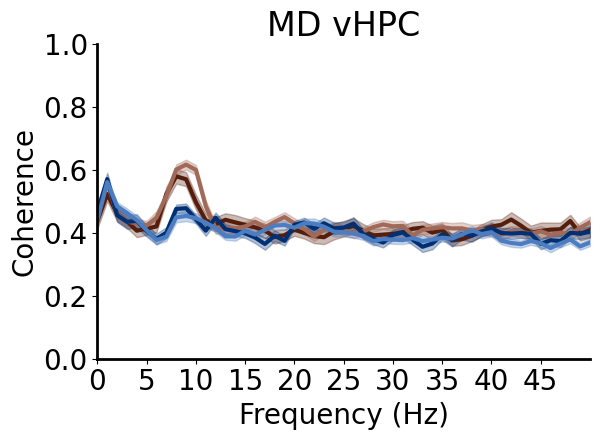

cluster_mean_trial_and_post_mPFC_vHPC_coherence_all_frequencies_all_windows


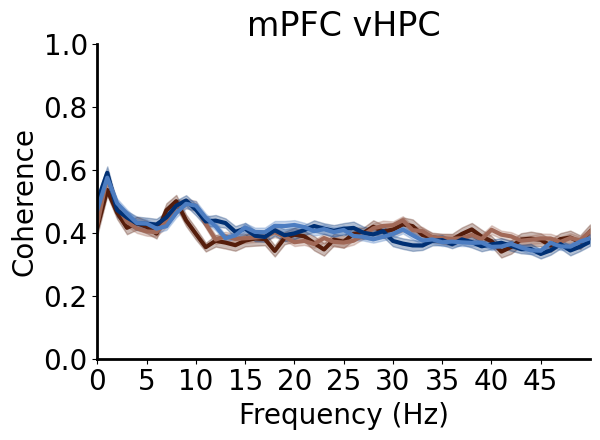

In [95]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each brain region
for col in cluster_mean_columns:
    if "all_frequencies" not in col:
        continue
    print(col)

    fig, ax = plt.subplots()
    plt.xlim(low_freq, high_freq-1) 
    plt.xticks(np.arange(low_freq, high_freq-1, 5))
    # plt.grid()

    # for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
    #     ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.3, label=band)

    stacked_df = power_exploded_TRIALS_AND_SPECTRAL_DF.groupby("power_cluster_id").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    
    # grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())

    stacked_df["color"] = stacked_df["power_cluster_id"].map(comp_id_to_color)

    stacked_df["max_value"] = stacked_df[col].apply(lambda x: np.nanmax(x[low_freq: high_freq]))
    max_value = np.nanmax(stacked_df["max_value"])
    
    # Iterating through each trial type
    for trial_label in stacked_df["power_cluster_id"].unique():
        if "tie" in trial_label:
            continue
        
        current_df = stacked_df[stacked_df["power_cluster_id"] == trial_label]
    
        if "power" in col:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            # plt.set_ylim(auto=True)
            plt.ylim()
            # plt.ylim(0, max_value)
        else:
            # pass
            plt.ylim(0, 1)

        # current_df["id_number"] = current_df["id_number"].astype(int)
        # Sample data: a list of numbers
        

        
        for index, row in current_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            # sem_power = stats.sem(row[col], axis=0, ddof=0)
            
            sem_power = np.nanstd(row[col], axis=0) / ((row[col].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   
            

            plt.plot(current_frequencies, mean_power, \
            label="{}".format(row["power_cluster_id"]), linewidth=3, color=row["color"])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.3, color=row["color"])
    
    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    
    if "power" in col:
        plt.ylabel("Normalized Power (a.u.)")
        output_dir = "./proc/cluster_spectra_plots/power"

    elif "coherence" in col:
        plt.ylabel("Coherence")
        output_dir = "./proc/cluster_spectra_plots/coherence"

    elif "granger" in col:
        plt.ylabel("Granger's Causality")
        output_dir = "./proc/cluster_spectra_plots/granger"
    
    os.makedirs(output_dir, exist_ok=True)

    # plt.legend(fontsize=10)

    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.tight_layout()    
    plt.savefig(os.path.join(output_dir, "cluster_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())))
    plt.show()


    







# Filtering for granger

In [96]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["cluster_filtered_granger_timestamps"].apply(lambda x: len(x)) >= 1] 

In [97]:
list(TRIALS_AND_SPECTRAL_DF.columns)

['tone_start_frame',
 'reward_start',
 'reward_dispensed',
 'tone_stop_frame',
 'condition ',
 'competition_closeness',
 'get_reward_frame',
 'out_reward_frame',
 'notes',
 'box_1_port_entry_frames',
 'box_2_port_entry_frames',
 'video_name',
 'tone_start_timestamp',
 'tone_stop_timestamp',
 'box_1_port_entry_timestamps',
 'box_2_port_entry_timestamps',
 'current_subject',
 'subject_tail_base',
 'agent_tail_base',
 'session_dir',
 'experiment',
 'sleap_name',
 'video_id',
 'agent',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'all_subjects',
 'coherence_calculation_frequencies',
 'cohort',
 'first_timestamp',
 'granger_calculation_frequencies',
 'last_timestamp',
 'mPFC_lfp_RMS_filtered',
 'power_calculation_frequencies',
 'recording',
 'session_path',
 'subject',
 'tone_frames',
 'tone_timestamps',
 'vHPC_lfp_RMS_filtered',
 'video_timestamps',
 'baseline_start_timestamp',
 'post_trial_end_timestamp',
 'video_frame',
 'trial_and_post_agent_locations',
 'tr

In [98]:
to_keep_columns = ['trial_label',
'tone_start_frame',
'reward_start',
'reward_dispensed',
'tone_stop_frame',
'condition ',
'competition_closeness',
'get_reward_frame',
'out_reward_frame',
'notes',
'box_1_port_entry_frames',
'box_2_port_entry_frames',
'video_name',
'tone_start_timestamp',
'tone_stop_timestamp',
'box_1_port_entry_timestamps',
'box_2_port_entry_timestamps',
'current_subject',
'session_dir',
'experiment',
'sleap_name',
'video_id',
'agent',
'all_subjects',
'cohort',
'first_timestamp',
'last_timestamp',
'recording',
'session_path',
'subject',
'baseline_start_timestamp',
'post_trial_end_timestamp',]

In [99]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF if "granger" in col and ("trial_and_post" in col or "cluster" in col)]

In [100]:
power_columns

['trial_and_post_BLA-to-LH_granger_gamma',
 'trial_and_post_BLA-to-LH_granger_theta',
 'trial_and_post_BLA-to-MD_granger_gamma',
 'trial_and_post_BLA-to-MD_granger_theta',
 'trial_and_post_BLA-to-mPFC_granger_gamma',
 'trial_and_post_BLA-to-mPFC_granger_theta',
 'trial_and_post_BLA-to-vHPC_granger_gamma',
 'trial_and_post_BLA-to-vHPC_granger_theta',
 'trial_and_post_BLA_LH_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_MD_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_mPFC_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_vHPC_granger_all_frequencies_all_windows',
 'trial_and_post_LH-to-BLA_granger_gamma',
 'trial_and_post_LH-to-BLA_granger_theta',
 'trial_and_post_LH-to-MD_granger_gamma',
 'trial_and_post_LH-to-MD_granger_theta',
 'trial_and_post_LH-to-mPFC_granger_gamma',
 'trial_and_post_LH-to-mPFC_granger_theta',
 'trial_and_post_LH-to-vHPC_granger_gamma',
 'trial_and_post_LH-to-vHPC_granger_theta',
 'trial_and_post_LH_BLA_granger_all_frequencies_al

- Making a separate row for each cluster

In [101]:
power_exploded_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[to_keep_columns + power_columns].explode(["cluster_filtered_granger_timestamps"])

In [102]:
power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_granger_timestamps"]

0      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
1      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
2      (lose_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
3      (win_no_comp, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1...
4        (lose_competitive, [1, 2, 3, 5, 6, 17, 18, 19])
                             ...                        
200    (lose_competitive, [4, 5, 6, 7, 15, 16, 17, 18...
200                  (lose_no_comp, [9, 10, 11, 12, 13])
202    (lose_no_comp, [4, 5, 6, 7, 8, 9, 10, 11, 12, ...
204    (tie_competitive, [0, 1, 4, 5, 6, 7, 8, 9, 10,...
204                                (tie_no_comp, [2, 3])
Name: cluster_filtered_granger_timestamps, Length: 252, dtype: object

- Making independent columns for cluster name and indexes

In [103]:
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_granger_timestamps"].apply(lambda x: x[0])
power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_indexes"] = power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_filtered_granger_timestamps"].apply(lambda x: x[1])

In [104]:
power_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "granger" in col and "trial_and_post" in col and "timestamps" not in col]

In [105]:
power_columns

['trial_and_post_BLA-to-LH_granger_gamma',
 'trial_and_post_BLA-to-LH_granger_theta',
 'trial_and_post_BLA-to-MD_granger_gamma',
 'trial_and_post_BLA-to-MD_granger_theta',
 'trial_and_post_BLA-to-mPFC_granger_gamma',
 'trial_and_post_BLA-to-mPFC_granger_theta',
 'trial_and_post_BLA-to-vHPC_granger_gamma',
 'trial_and_post_BLA-to-vHPC_granger_theta',
 'trial_and_post_BLA_LH_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_MD_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_mPFC_granger_all_frequencies_all_windows',
 'trial_and_post_BLA_vHPC_granger_all_frequencies_all_windows',
 'trial_and_post_LH-to-BLA_granger_gamma',
 'trial_and_post_LH-to-BLA_granger_theta',
 'trial_and_post_LH-to-MD_granger_gamma',
 'trial_and_post_LH-to-MD_granger_theta',
 'trial_and_post_LH-to-mPFC_granger_gamma',
 'trial_and_post_LH-to-mPFC_granger_theta',
 'trial_and_post_LH-to-vHPC_granger_gamma',
 'trial_and_post_LH-to-vHPC_granger_theta',
 'trial_and_post_LH_BLA_granger_all_frequencies_al

- Getting the timestamps of all the clusters

In [106]:
for col in power_columns:
    power_exploded_TRIALS_AND_SPECTRAL_DF["cluster_all_{}".format(col)] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: x[col][x["power_cluster_indexes"]], axis=1)

In [107]:
cluster_all_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_all" in col]

In [108]:
cluster_all_columns

['cluster_all_trial_and_post_BLA-to-LH_granger_gamma',
 'cluster_all_trial_and_post_BLA-to-LH_granger_theta',
 'cluster_all_trial_and_post_BLA-to-MD_granger_gamma',
 'cluster_all_trial_and_post_BLA-to-MD_granger_theta',
 'cluster_all_trial_and_post_BLA-to-mPFC_granger_gamma',
 'cluster_all_trial_and_post_BLA-to-mPFC_granger_theta',
 'cluster_all_trial_and_post_BLA-to-vHPC_granger_gamma',
 'cluster_all_trial_and_post_BLA-to-vHPC_granger_theta',
 'cluster_all_trial_and_post_BLA_LH_granger_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_MD_granger_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_mPFC_granger_all_frequencies_all_windows',
 'cluster_all_trial_and_post_BLA_vHPC_granger_all_frequencies_all_windows',
 'cluster_all_trial_and_post_LH-to-BLA_granger_gamma',
 'cluster_all_trial_and_post_LH-to-BLA_granger_theta',
 'cluster_all_trial_and_post_LH-to-MD_granger_gamma',
 'cluster_all_trial_and_post_LH-to-MD_granger_theta',
 'cluster_all_trial_and_post_LH-to

- Aggregating all the values within a given trial

In [109]:
for col in cluster_all_columns:
    updated_column = col.replace("cluster_all", "cluster_mean")
    if "gamma" in col or "theta" in col:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col]), axis=1)
    else:
        power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column] = power_exploded_TRIALS_AND_SPECTRAL_DF.apply(lambda x: np.nanmean(x[col], axis=0), axis=1)
    print(updated_column)
    print(power_exploded_TRIALS_AND_SPECTRAL_DF[updated_column].iloc[0])
        

cluster_mean_trial_and_post_BLA-to-LH_granger_gamma
0.3664208
cluster_mean_trial_and_post_BLA-to-LH_granger_theta
0.30660522
cluster_mean_trial_and_post_BLA-to-MD_granger_gamma
0.2942613
cluster_mean_trial_and_post_BLA-to-MD_granger_theta
0.45820546
cluster_mean_trial_and_post_BLA-to-mPFC_granger_gamma
0.2930258
cluster_mean_trial_and_post_BLA-to-mPFC_granger_theta
0.27307668
cluster_mean_trial_and_post_BLA-to-vHPC_granger_gamma
0.23452348
cluster_mean_trial_and_post_BLA-to-vHPC_granger_theta
0.36626264
cluster_mean_trial_and_post_BLA_LH_granger_all_frequencies_all_windows
[1.0257977  0.6344437  0.33780724 0.35457605 0.16831335 0.5153097
 0.8596308  0.2813175  0.28944767 0.2282733  0.18002933 0.13649812
 0.10062707 0.1452421  0.6454303  0.6841519  0.5618222  0.34175172
 0.08889108 0.0486825  0.09072714 0.39492786 0.33689055 0.254558
 0.30413705 0.22812958 0.16740966 0.11070613 0.3719651  0.43107012
 0.54375154 0.72622955 0.3274906  0.15465167 0.1772635  0.18499105
 1.1659102  0.1640701

In [110]:
cluster_mean_columns = [col for col in power_exploded_TRIALS_AND_SPECTRAL_DF if "cluster_mean" in col]

In [111]:
cluster_mean_columns

['cluster_mean_trial_and_post_BLA-to-LH_granger_gamma',
 'cluster_mean_trial_and_post_BLA-to-LH_granger_theta',
 'cluster_mean_trial_and_post_BLA-to-MD_granger_gamma',
 'cluster_mean_trial_and_post_BLA-to-MD_granger_theta',
 'cluster_mean_trial_and_post_BLA-to-mPFC_granger_gamma',
 'cluster_mean_trial_and_post_BLA-to-mPFC_granger_theta',
 'cluster_mean_trial_and_post_BLA-to-vHPC_granger_gamma',
 'cluster_mean_trial_and_post_BLA-to-vHPC_granger_theta',
 'cluster_mean_trial_and_post_BLA_LH_granger_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_MD_granger_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_mPFC_granger_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_BLA_vHPC_granger_all_frequencies_all_windows',
 'cluster_mean_trial_and_post_LH-to-BLA_granger_gamma',
 'cluster_mean_trial_and_post_LH-to-BLA_granger_theta',
 'cluster_mean_trial_and_post_LH-to-MD_granger_gamma',
 'cluster_mean_trial_and_post_LH-to-MD_granger_theta',
 'cluster_mean_tri

In [112]:
OUTCOME_TO_COLOR = {"both_rewarded": "green", 
"novel_lose": "#e67073",
"novel_win": "#93a5da",
"lose": "#951a1d",
"alone_rewarded": "#0499af",
"win": "#3853a3",
"omission": "orange",
"tie": "green"}

In [113]:
# for col in cluster_mean_columns:
#     if "all_frequencies" in col:
#         continue
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = pd.DataFrame(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].mean())
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF.reset_index()



#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)
#     grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["id_number"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].apply(lambda x: x.split("_")[0]).map(OUTCOME_TO_COLOR)

    
    
#     fig, ax = plt.subplots()
#     plt.bar(grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"], grouped_power_exploded_TRIALS_AND_SPECTRAL_DF[col], color=grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["color"])
#     plt.title(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", ""))
#     plt.xticks(rotation=90, ha='right')
#     plt.show()

cluster_mean_trial_and_post_BLA_LH_granger_all_frequencies_all_windows


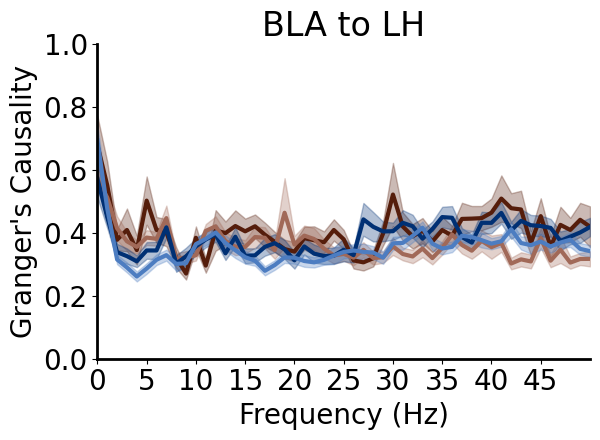

cluster_mean_trial_and_post_BLA_MD_granger_all_frequencies_all_windows


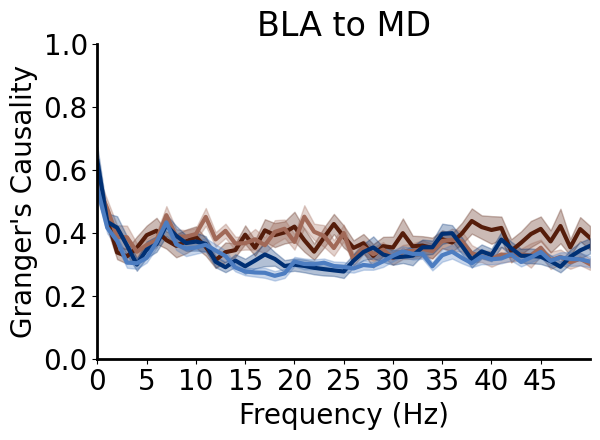

cluster_mean_trial_and_post_BLA_mPFC_granger_all_frequencies_all_windows


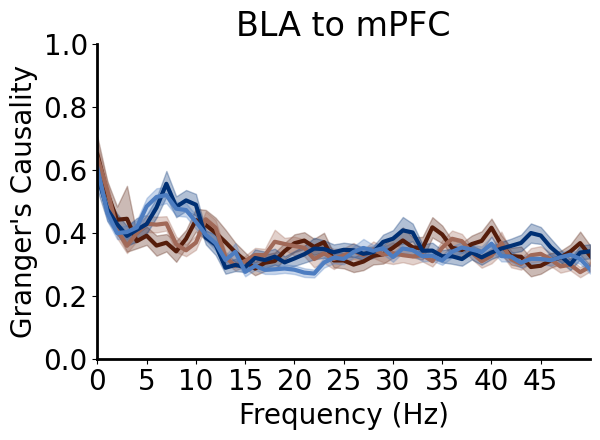

cluster_mean_trial_and_post_BLA_vHPC_granger_all_frequencies_all_windows


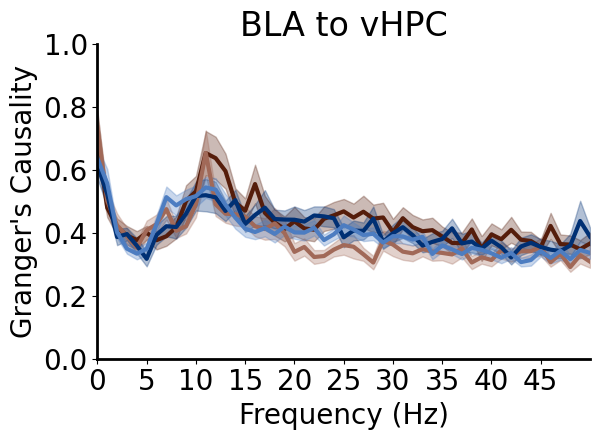

cluster_mean_trial_and_post_LH_BLA_granger_all_frequencies_all_windows


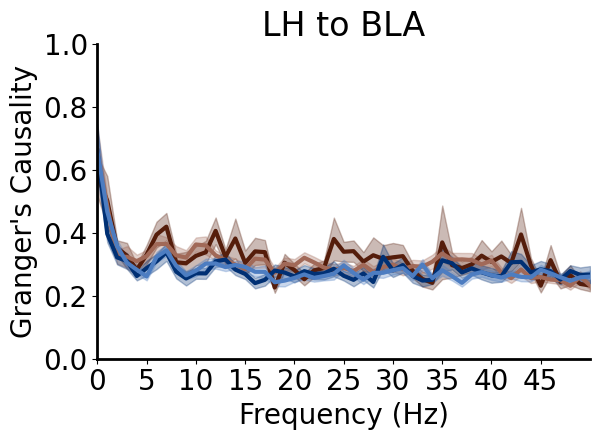

cluster_mean_trial_and_post_LH_MD_granger_all_frequencies_all_windows


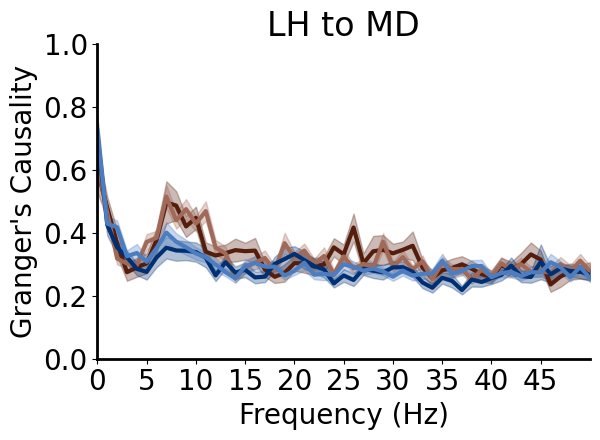

cluster_mean_trial_and_post_LH_mPFC_granger_all_frequencies_all_windows


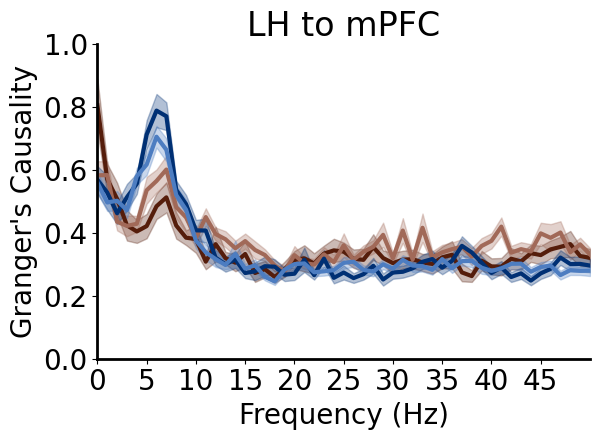

cluster_mean_trial_and_post_LH_vHPC_granger_all_frequencies_all_windows


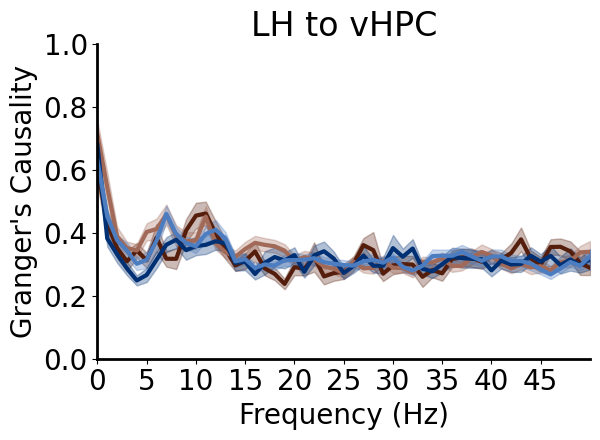

cluster_mean_trial_and_post_MD_BLA_granger_all_frequencies_all_windows


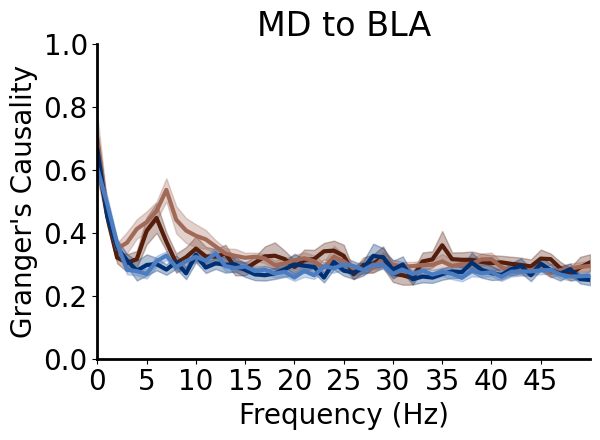

cluster_mean_trial_and_post_MD_LH_granger_all_frequencies_all_windows


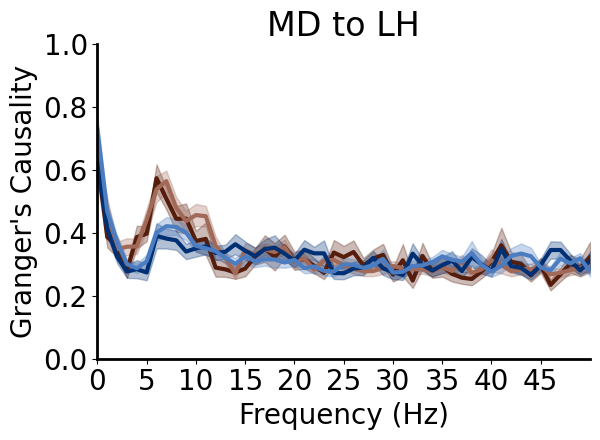

cluster_mean_trial_and_post_MD_mPFC_granger_all_frequencies_all_windows


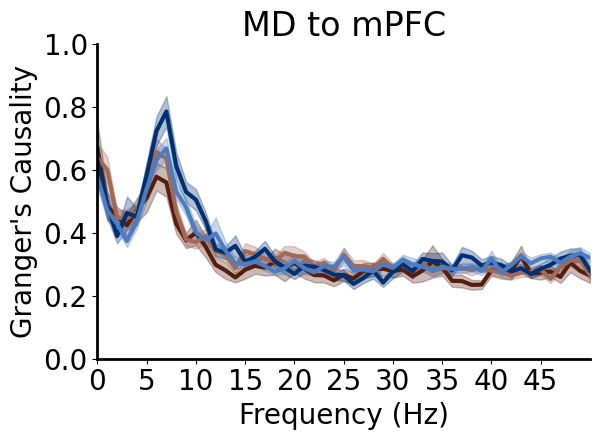

cluster_mean_trial_and_post_MD_vHPC_granger_all_frequencies_all_windows


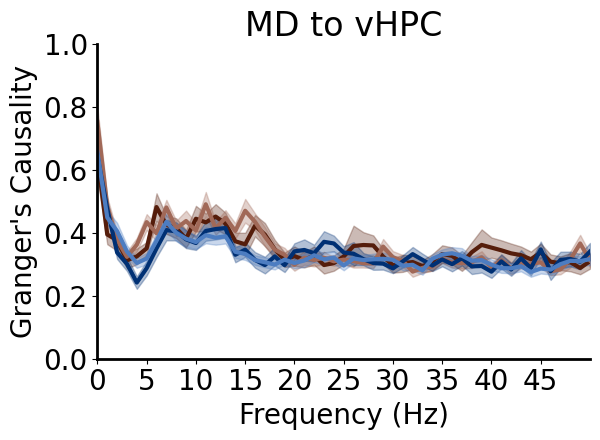

cluster_mean_trial_and_post_mPFC_BLA_granger_all_frequencies_all_windows


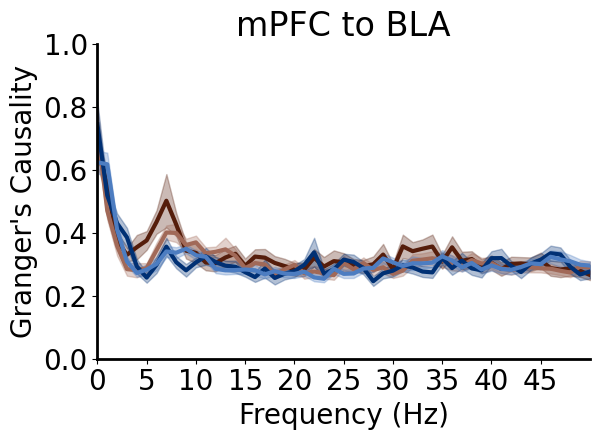

cluster_mean_trial_and_post_mPFC_LH_granger_all_frequencies_all_windows


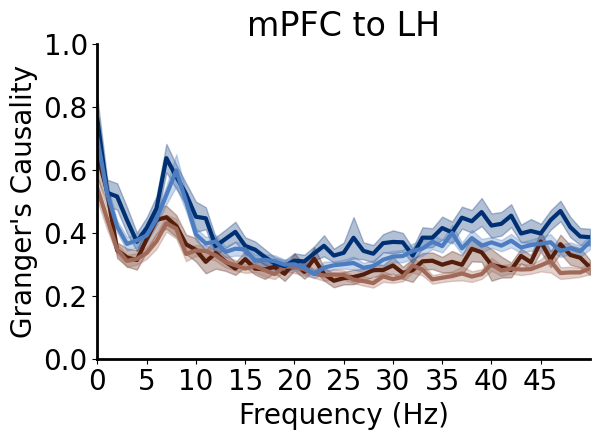

cluster_mean_trial_and_post_mPFC_MD_granger_all_frequencies_all_windows


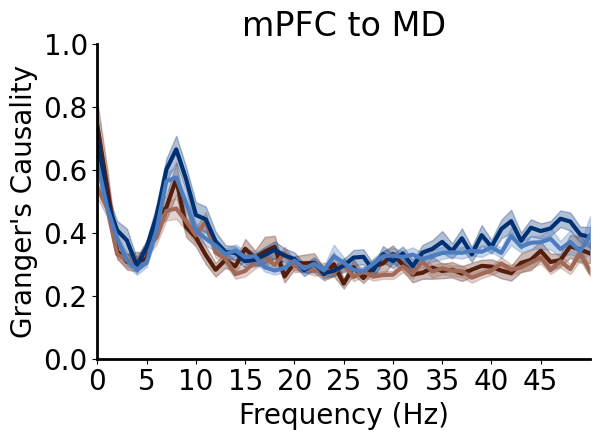

cluster_mean_trial_and_post_mPFC_vHPC_granger_all_frequencies_all_windows


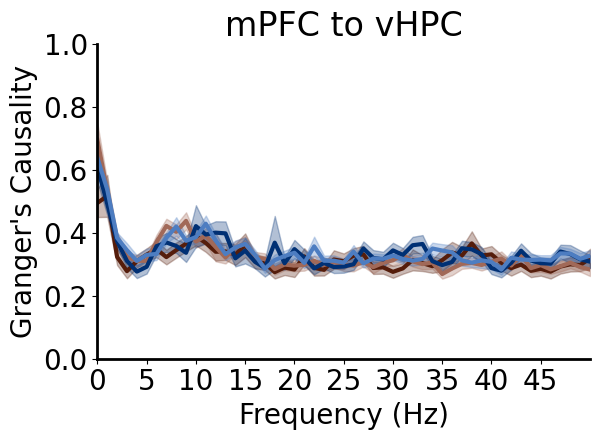

cluster_mean_trial_and_post_vHPC_BLA_granger_all_frequencies_all_windows


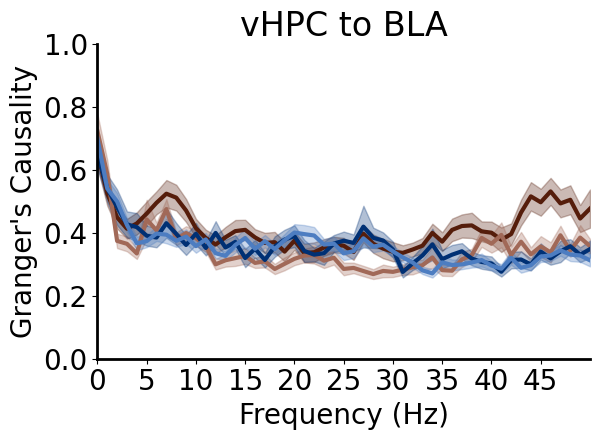

cluster_mean_trial_and_post_vHPC_LH_granger_all_frequencies_all_windows


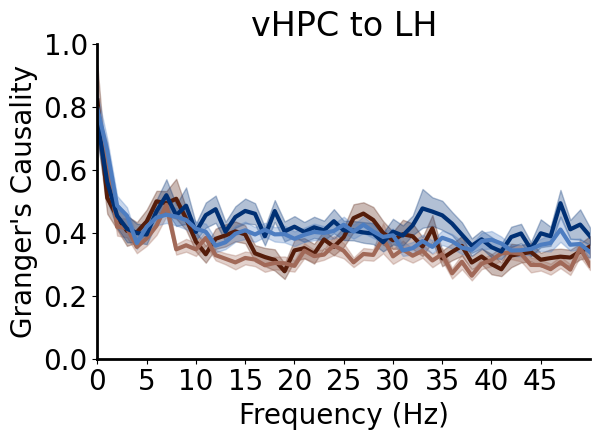

cluster_mean_trial_and_post_vHPC_MD_granger_all_frequencies_all_windows


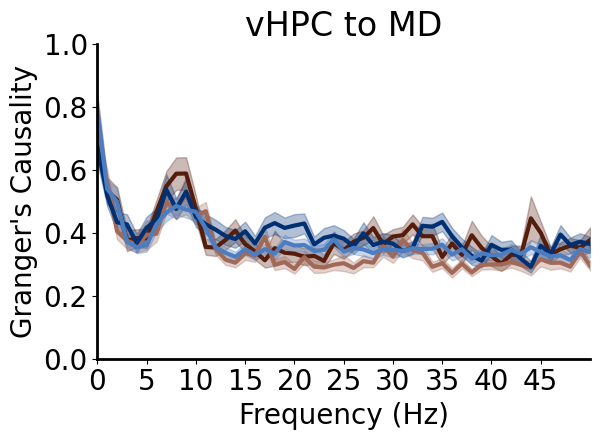

cluster_mean_trial_and_post_vHPC_mPFC_granger_all_frequencies_all_windows


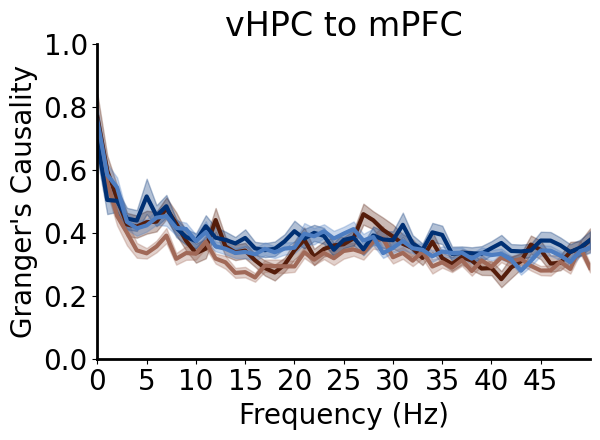

In [114]:
low_freq = 0
high_freq = 51
current_frequencies = range(low_freq, high_freq)

# Iterating through each brain region
for col in cluster_mean_columns:
    if "all_frequencies" not in col:
        continue
    print(col)

    fig, ax = plt.subplots()
    plt.xlim(low_freq, high_freq-1) 
    plt.xticks(np.arange(low_freq, high_freq-1, 5))
    # plt.grid()

    # for band, (min_freq, max_freq) in BAND_TO_FREQ_PLOT.items():
    #     ax.axvspan(min_freq, max_freq, facecolor=BAND_TO_FREQ_COLOR[band], alpha=0.3, label=band)

    stacked_df = power_exploded_TRIALS_AND_SPECTRAL_DF.groupby("power_cluster_id").agg({col: stack_arrays})
    stacked_df = stacked_df.reset_index()
    
    # grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["sem"] = grouped_power_exploded_TRIALS_AND_SPECTRAL_DF["power_cluster_id"].map(power_exploded_TRIALS_AND_SPECTRAL_DF.groupby('power_cluster_id')[col].sem().to_dict())

    stacked_df["color"] = stacked_df["power_cluster_id"].map(comp_id_to_color)

    stacked_df["max_value"] = stacked_df[col].apply(lambda x: np.nanmax(x[low_freq: high_freq]))
    max_value = np.nanmax(stacked_df["max_value"])
    
    # Iterating through each trial type
    for trial_label in stacked_df["power_cluster_id"].unique():
        if "tie" in trial_label:
            continue
        
        current_df = stacked_df[stacked_df["power_cluster_id"] == trial_label]
    
        if "power" in col:
            # plt.ylim(0,0.01)
            # plt.yscale("log")
            # plt.ylim((10**-3.5,10**-0.5))
            # plt.set_ylim(auto=True)
            plt.ylim()
            # plt.ylim(0, max_value)
        else:
            # pass
            plt.ylim(0, 1)

        # current_df["id_number"] = current_df["id_number"].astype(int)
        # Sample data: a list of numbers
        

        
        for index, row in current_df.iterrows():   
            #### DURING TRIAL ####
            mean_power = np.nanmean(row[col], axis=0)[low_freq: high_freq]
            
            # nans, x= nan_helper(mean_power)
            # mean_power[nans]= np.interp(x(nans), x(~nans), mean_power[~nans])
            # sem_power = stats.sem(row[col], axis=0, ddof=0)
            
            sem_power = np.nanstd(row[col], axis=0) / ((row[col].shape[0])**0.5)
            sem_power = sem_power[low_freq: high_freq]
            # nans, x= nan_helper(sem_power)
            # sem_power[nans]= np.interp(x(nans), x(~nans), sem_power[~nans])   
            

            plt.plot(current_frequencies, mean_power, \
            label="{}".format(row["power_cluster_id"]), linewidth=3, color=row["color"])

            plt.fill_between(current_frequencies, 
            mean_power - sem_power, mean_power + sem_power, \
            alpha=0.3, color=row["color"])
    
    if "granger" in col:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip().replace(" ", " to ").strip()
    else:
        title = "{}".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").replace("power", "").replace("granger", "")).replace("coherence", "").replace("_", " ").replace("  ", " ").strip()

    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    
    if "power" in col:
        plt.ylabel("Normalized Power (a.u.)")
        output_dir = "./proc/cluster_spectra_plots/power"

    elif "coherence" in col:
        plt.ylabel("Coherence")
        output_dir = "./proc/cluster_spectra_plots/coherence"

    elif "granger" in col:
        plt.ylabel("Granger's Causality")
        output_dir = "./proc/cluster_spectra_plots/granger"
    
    os.makedirs(output_dir, exist_ok=True)

    # plt.legend(fontsize=10)

    # Hide top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Leave bottom and left spines
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.tight_layout()    
    plt.savefig(os.path.join(output_dir, "cluster_{}.png".format(col.replace("cluster_mean_trial_and_post_", "").replace("RMS_filtered_", "").replace("all_frequencies_all_windows", "").strip("_").strip())))
    plt.show()


    







In [115]:
raise ValueError()

ValueError: 

- Grouping all the rows with the same video and subject together

In [ ]:
list(TRIALS_AND_SPECTRAL_DF.columns)

In [ ]:
explode_columns

In [ ]:
other_explode_columns = ["tone_stop_frame",
                         "condition ",
                         "competition_closeness",
                         "notes",
                         "10s_before_tone_frame",
                         "10s_after_tone_frame",
                        'cluster_index_ranges_dict',
 'cluster_times',
 'cluster_times_ranges_dict',
 'cluster_timestamps_ranges_dict',
 'trial_cluster_times_ranges_dict',
 'trial_cluster_timestamps_ranges_dict']

In [ ]:
filter_columns

In [ ]:
# Define columns to be transformed into numpy arrays


# Define aggregation dictionary
agg_dict = {col: list for col in explode_columns + other_explode_columns if col not in groupby_columns and col != "tone_start_frame"}

agg_dict.update({col: 'first' for col in filter_columns + ["tone_start_frame"] if col not in groupby_columns and col not in other_explode_columns})

# Apply groupby and aggregation
video_TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.groupby(["video_name", "current_subject"]).agg(agg_dict).reset_index()


In [ ]:
video_TRIALS_AND_SPECTRAL_DF.columns

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.head()

- Combining all the dictionaries together

In [ ]:
for col in [_ for _ in video_TRIALS_AND_SPECTRAL_DF if "dict" in _]:
    video_TRIALS_AND_SPECTRAL_DF[col] = video_TRIALS_AND_SPECTRAL_DF[col].apply(lambda x: combine_dicts(x))

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
video_TRIALS_AND_SPECTRAL_DF.to_pickle("./proc/{}_cluster_ranges.pkl".format(OUTPUT_PREFIX))

# Filtering out the SLEAP posed for during trials

In [ ]:
raise ValueError()

In [ ]:
TRIALS_AND_SPECTRAL_DF

In [ ]:
TRIALS_AND_SPECTRAL_DF["video_frame"] = TRIALS_AND_SPECTRAL_DF["video_timestamps"].apply(lambda x: np.array(list(range(len(x)))) + 1)

In [ ]:
TRIALS_AND_SPECTRAL_DF["video_frame"].head().apply(lambda x: x.shape)

In [ ]:
['subject_thorax_to_agent_thorax',
 'nose_to_reward_port_sum',
 'nose_to_reward_port_diff',
 'thorax_velocity_sum',
 'thorax_velocity_diff',
 'to_reward_port_angle_sum',
 'to_reward_port_angle_diff',
 'subject_nose_to_reward_port',
 'subject_thorax_velocity',
 'subject_to_reward_port_angle',
 'agent_nose_to_reward_port',
 'agent_thorax_velocity',
 'agent_to_reward_port_angle',
 'closebool_subject_nose_to_reward_port',
 'closebool_agent_nose_to_reward_port',
 'movingbool_subject_thorax_velocity',
 'movingbool_agent_thorax_velocity',
 'manual_cluster_id',
 'standard_embedding_x',
 'standard_embedding_y',
 'kmeans_cluster',
 'subject_locations',
 'agent_locations',
 'subject_thorax',
 'subject_nose',
 'subject_tail_base',
 'agent_thorax',
 'agent_nose',
 'agent_tail_base']

In [ ]:
# sleap_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "locations" in col or "velocity" in col or "to_reward_port" in col or "video_frame" in col]

In [ ]:
sleap_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if ("thorax" in col or "nose" in col or "reward_port" in col or "standard_embedding" in col or "cluster" in col or "frame_index" in col or "locations" in col or "tailbase" in col) and "timestamp" not in col]


In [ ]:
sleap_columns

In [ ]:
for col in sleap_columns:
    print(col)
    print(TRIALS_AND_SPECTRAL_DF[col].apply(lambda x: x.shape).iloc[0])

In [ ]:
for col in sorted(sleap_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_video_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["cluster_timestamp"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["cluster_timestamp"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_frame_index"].iloc[0].shape

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=sleap_columns + ["cluster_timestamp"], errors="ignore")

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF.columns:
    print(col)

- Filtering coherence

In [ ]:
coherence_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "coherence" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
coherence_columns

In [ ]:
for col in sorted(coherence_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_coherence_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["coherence_timestamps"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=coherence_columns + ["coherence_timestamps"], errors="ignore")

- Filtering Grangers

In [ ]:
granger_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "granger" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
granger_columns

In [ ]:
for col in sorted(granger_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_granger_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["granger_timestamps"], items=x[col])[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=granger_columns + ["granger_timestamps"], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

- Filtering power

In [ ]:
TRIALS_AND_SPECTRAL_DF.head()

In [ ]:
power_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "power" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
power_columns

In [ ]:
for col in sorted(power_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_power_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["power_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["power_timestamps"], items=x[col])[0], axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=power_columns + ["power_timestamps"], errors="ignore")

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF:
    print(col)

# Filtering out phase

In [ ]:
lfp_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "trace" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
band_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "band" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
phase_columns = [col for col in TRIALS_AND_SPECTRAL_DF.columns if "phase" in col and "timestamps" not in col and "calculation" not in col]

In [ ]:
phase_columns = phase_columns + band_columns +lfp_columns

In [ ]:
phase_columns

In [ ]:
for col in sorted(phase_columns):
    updated_item_col = "trial_and_post_{}".format(col)
    print(updated_item_col)
    updated_timestamp_col = "trial_and_post_lfp_timestamps"
    TRIALS_AND_SPECTRAL_DF[updated_item_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["lfp_timestamps"], items=x[col])[1], axis=1)

TRIALS_AND_SPECTRAL_DF[updated_timestamp_col] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["post_trial_end_timestamp"], timestamps=x["lfp_timestamps"], items=x[col])[0], axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_lfp_timestamps"]

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=phase_columns + ["lfp_timestamps"], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
for col in TRIALS_AND_SPECTRAL_DF:
    print(col)

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_and_post_kmeans_cluster"].iloc[0].shape

In [ ]:
raise ValueError()

# Filtering for rows that are in the video

In [ ]:
TRIALS_AND_SPECTRAL_DF["in_video"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: x["start_frame"] <= x["trial_video_frame"][0] <= x["stop_frame"], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF[TRIALS_AND_SPECTRAL_DF["in_video"]].reset_index()

In [ ]:
TRIALS_AND_SPECTRAL_DF

In [ ]:
TRIALS_AND_SPECTRAL_DF.to_pickle(os.path.join(OUTPUT_DIR, FULL_LFP_TRACES_PKL))

In [ ]:
raise ValueError()

# Filtering out spikes

In [ ]:
raise ValueError()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_spike_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: filter_spike_times(x["spike_times"], start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"]).astype(int), axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_spike_times"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: filter_spike_times(x["spike_times"], start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"]).astype(int), axis=1)


In [ ]:
TRIALS_AND_SPECTRAL_DF["tone_start_timestamp"].head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_stop_timestamp"].head()

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_spike_times"].iloc[0]

In [ ]:
TRIALS_AND_SPECTRAL_DF["baseline_neuron_average_fr"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[1], axis=1)
TRIALS_AND_SPECTRAL_DF["baseline_neuron_average_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["baseline_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_fr"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[1].T, axis=1)
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_timestamp"] = TRIALS_AND_SPECTRAL_DF.apply(lambda x: utilities.helper.filter_by_timestamp_range(start=x["tone_start_timestamp"], stop=x["tone_stop_timestamp"], timestamps=x["neuron_average_timestamps"], items=x["neuron_average_fr"].T)[0], axis=1)

In [ ]:
TRIALS_AND_SPECTRAL_DF = TRIALS_AND_SPECTRAL_DF.drop(columns=["spike_clusters", "spike_times", "neuron_average_fr", "neuron_average_timestamps",], errors="ignore")

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_fr"].iloc[0].shape

In [ ]:
TRIALS_AND_SPECTRAL_DF["trial_neuron_average_timestamp"].iloc[0].shape